In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tf.compat.v1.disable_eager_execution()

Funcionalidade das bibliotecas que foram utilizadas:

- Numpy: Facilita algumas operações e manipulações matematicas, e permite a captura da forma vetorial das imagens.
- os: Fornece algumas funções de manipulação do proprio sistema operacional que foram uteis para testes feitos antes da integração com a base de dados.
- Matplotlib: Fornece funções para plotar os graficos do comportamento do erro calculado ao longo do tempo
- cv2: Permite o redimensionamento das imagens.
- sklearn: Biblioteca de aprendizagem de maquina da qual foi utilizada as funções que auxiliaram no processamento dos dados de entrada
- TensorFlow: Biblioteca matematica e estatistica usada para implementar o perceptron





Considerando uma implementação através de manipulação de arquivos para a base de dados:

É pego a lista de diretórios do caminho atual, e então atribuido a uma lista. Esses diretórios são as categorias de veiculos que serão avaliadas, no caso, Aviões e Barcos.

In [3]:
vehicle_types = os.listdir('Dataset/imgs//')
vehicle_types

['airplanes', 'ship']

Então, para cada diretório que foi descoberto é feita uma varredura, e atribuida cada imagem que está no formato jpg para a lista de imagens, e a sua categoria correspondente para a lista de labels.

In [4]:
path = 'Dataset/imgs//'

sizeExpected = 16

images = []
labels = []

for i in vehicle_types:
    data_path = path + str(i)
    filenames = [i for i in os.listdir(data_path) if i.endswith('.jpg')]
    print(filenames)
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img,(sizeExpected, sizeExpected))
        images.append(img)
        labels.append(i)

['airplane1.jpg', 'airplane10.jpg', 'airplane11.jpg', 'airplane13.jpg', 'airplane14.jpg', 'airplane15.jpg', 'airplane16.jpg', 'airplane17.jpg', 'airplane19.jpg', 'airplane2.jpg', 'airplane20.jpg', 'airplane21.jpg', 'airplane22.jpg', 'airplane23.jpg', 'airplane25.jpg', 'airplane26.jpg', 'airplane27.jpg', 'airplane28.jpg', 'airplane29.jpg', 'airplane3.jpg', 'airplane31.jpg', 'airplane32.jpg', 'airplane33.jpg', 'airplane34.jpg', 'airplane35.jpg', 'airplane37.jpg', 'airplane38.jpg', 'airplane39.jpg', 'airplane4.jpg', 'airplane40.jpg', 'airplane41.jpg', 'airplane45.jpg', 'airplane46.jpg', 'airplane47.jpg', 'airplane49.jpg', 'airplane5.jpg', 'airplane50.jpg', 'airplane7.jpg', 'airplane8.jpg', 'airplane9.jpg']
['299281.jpg', '299795.jpg', '299796.jpg', '299803.jpg', '299806.jpg', '317425.jpg', '337456.jpg', '382937.jpg', '389050.jpg', '427198.jpg', '554491.jpg', '560394.jpg', '563043.jpg', '565155.jpg', '567270.jpg', '567497.jpg', '567503.jpg', '573909.jpg', '580622.jpg', '584420.jpg', '58871

Com isso, pode-se converter as imagens em questão para sua forma vetorial, garantir que estejam no formato correto (Float32) e sobre a escala de cinza

Com a função shape podemos ver que o primeiro elemento da 3-tupla é a quantidade de imagens que foram pegas, os proximos dois são a dimensão que foi escolhida para análise.

In [5]:
images = np.array(images)
images = images.astype('float32')/255
images.shape

(80, 16, 16)

Com as funções fornecidas pela biblioteca sklearn podemos começar a criação e atribuição de labels para o treinamento. Dessa forma, a variavel x recebe a lista de imagens pegas, e a y recebe a lista binária de labels (o que permite que as labels sejam "entendidas" pelo computador), onde no nosso caso, seria:
- 0 para Aviões
- 1 para Barcos.

In [6]:
x = images
y = labels
y_labelEncoder = LabelEncoder()
y = y_labelEncoder.fit_transform(y)
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]


Nesse momento é separado as labels em duas classes já que precisamos de duas colunas de classificação.

In [7]:
y = y.reshape(-1,1)

ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
y = ct.fit_transform(y)
print(y)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


Neste momento é feita a separação entre treino e teste.

In [8]:
x,Y = shuffle(x,y, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.375, random_state=415)

In [9]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(50, 16, 16)
(50, 2)
(30, 16, 16)
(30, 2)


Como o objetivo é utilizar um perceptron para resolver o problema da classificação, precisamos transformar o formato da imagem para apenas uma dimensão. Dessa forma, temos que:

Nova dimensão = (n, r * r)

Sendo o n o valor do primeiro elemento da 3-tupla da célula anterior (o numero de imagens do treino e do teste), e r o numéro que redimensionamos a imagem anteriormente.

Logo:
- Para o treino:    Nova dimensão = (50, 256)
- Para o teste:     Nova dimensão = (30, 256)

In [10]:
train_x=np.reshape(train_x,(50,256))
print(train_x.shape)

test_x=np.reshape(test_x,(30,256))
test_x.shape

(50, 256)


(30, 256)

Com isso, podemos começar a implementação do perceptron com o auxilio do tensorflow. Primeiro é definida algumas variaveis importantes que seram usadas na implementação da rede, e do treinamento:
- A taxa de aprendizado = 0.1
- Quantidade de epocas = 30
- Numero de classes possiveis para classificação. (Aviões ou Barcos)

Então, podemos definir as variaveis que seram usadas na implementação do perceptron em si, seguindo as variaveis da equação conhecida:

wi.xi + b <= 0

Dessa forma, definimos:
- O vetor de pesos W
- O vetor de entrada X
- O valor do bias como um valor aleatório
- O formato da saida y como duas possiveis classes


In [11]:
learning_rate = 0.10
training_epochs = 100
n_class=2


Perceptron_x = tf.compat.v1.placeholder(tf.float32, [None, 256])
Perceptron_W = tf.Variable(tf.zeros([256,n_class]))
Perceptron_b = tf.Variable(tf.zeros([n_class]))
Perceptron_y = tf.compat.v1.placeholder(tf.float32,[None,n_class]) 

Podemos então definir o perceptron como a equação já mencionada e as variaveis definidas, além da função de erro e do passo de treinamento:

In [12]:
init = tf.compat.v1.global_variables_initializer()
pred = tf.nn.softmax(tf.matmul(Perceptron_x, Perceptron_W)+ Perceptron_b) # perceptron
 
error_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=Perceptron_y)) 
training_step = tf.compat.v1.train.GradientDescentOptimizer(learning_rate).minimize(error_function)


Com tudo pronto, podemos iniciar o treinamento da nossa rede perceptron. Nele, podemos ver o valor do erro (custo) calculado para cada epoca, e adicionaremos cada erro a uma lista para podemos ver o comportamento do erro ao longo do tempo.

In [13]:

sess = tf.compat.v1.Session()
sess.run(init)

cost_history = []

In [14]:
for epoch in range(training_epochs):
    sess.run(training_step,feed_dict={Perceptron_x:train_x,Perceptron_y:train_y})
    cost = sess.run(error_function,feed_dict={Perceptron_x: train_x,Perceptron_y: train_y})
    cost_history = np.append(cost_history,cost)
    print('epoch : ', epoch+1,  ' - ', 'cost: ', cost)


epoch :  1  -  cost:  0.6899784
epoch :  2  -  cost:  0.6870388
epoch :  3  -  cost:  0.68415904
epoch :  4  -  cost:  0.6813374
epoch :  5  -  cost:  0.6785744
epoch :  6  -  cost:  0.67586935
epoch :  7  -  cost:  0.67322236
epoch :  8  -  cost:  0.67063284
epoch :  9  -  cost:  0.6680998
epoch :  10  -  cost:  0.6656227
epoch :  11  -  cost:  0.66320044
epoch :  12  -  cost:  0.6608319
epoch :  13  -  cost:  0.6585159
epoch :  14  -  cost:  0.65625113
epoch :  15  -  cost:  0.65403634
epoch :  16  -  cost:  0.65187025
epoch :  17  -  cost:  0.6497515
epoch :  18  -  cost:  0.64767855
epoch :  19  -  cost:  0.64565015
epoch :  20  -  cost:  0.643665
epoch :  21  -  cost:  0.64172167
epoch :  22  -  cost:  0.63981885
epoch :  23  -  cost:  0.6379551
epoch :  24  -  cost:  0.63612944
epoch :  25  -  cost:  0.63434035
epoch :  26  -  cost:  0.6325867
epoch :  27  -  cost:  0.63086736
epoch :  28  -  cost:  0.62918115
epoch :  29  -  cost:  0.62752694
epoch :  30  -  cost:  0.6259037
epo

Com isso, podemos ver que alcançamos um custo final de aproximadamente 0.63. Um gráfico mostrando o comportamento do valor do custo ao longo das epocas pode ser visto abaixo:



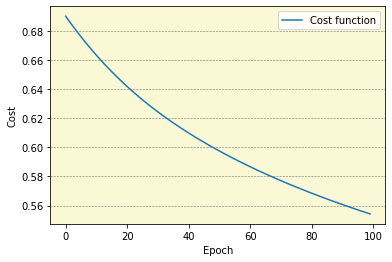

In [15]:
fig, ax = plt.subplots()
ax.plot(cost_history, label='Cost function')
ax.legend()
ax.grid(color='grey', linestyle='--', linewidth=0.6, axis='y')
ax.set_facecolor('#FBF8D5')
ax.set_ylabel('Cost')
ax.set_xlabel('Epoch')
plt.show()

Depois do treinamento, podemos então fazer uma tentativa de previsão. Primeiro realizo o tratamento da imagem necessário para usar a função de previsão da estruta perceptron criada:


In [16]:
img = cv2.imread('test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(sizeExpected, sizeExpected))
img = np.array(img)

print(img.shape)
image = np.reshape(img,(1,256))

(16, 16)


Então realizamos a previsão:

In [17]:
result = sess.run(pred, feed_dict={Perceptron_x: image})
print(result)

if(result[0][0] > result[0][1]):
    print("Avião")
else:
    print("Barco")

[[0. 1.]]
Barco
